In [1]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import scanpy as sc
import pandas as pd
import torch
import scipy
import time
from sklearn.neighbors import RadiusNeighborsTransformer

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
stadata = sc.read_h5ad('processed/stadata1.h5ad')
stadata2 = sc.read_h5ad('processed/stadata2.h5ad')
stadata3 = sc.read_h5ad('processed/stadata3.h5ad')
stadata4 = sc.read_h5ad('processed/stadata4.h5ad')

sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)

sc.pp.normalize_total(stadata2)
sc.pp.log1p(stadata2)

sc.pp.normalize_total(stadata3)
sc.pp.log1p(stadata3)

sc.pp.normalize_total(stadata4)
sc.pp.log1p(stadata4)

In [3]:
scadata = sc.read_h5ad('processed/scadata1_allsc.h5ad')
sc.pp.normalize_total(scadata)
sc.pp.log1p(scadata)
# scsubadata1 = scsubadata[scsubadata.obs.annot.isin(['Endothelial cells'])]
# scsubadata2 = scsubadata[~scsubadata.obs.annot.isin(['Endothelial cells'])]

In [4]:
scadata.obs.annot.value_counts()

Endothelial cells                     3093
Hepatocytes                           2279
Kupffer cells                         2141
Neutrophils                           1526
Monocytes & Monocyte-derived cells    1497
B cells                               1484
T cells                               1445
pDCs                                  1009
Fibroblasts                            980
cDC1s                                  604
ILC1s                                  481
cDC2s                                  445
NK cells                               248
Mig. cDCs                               82
Cholangiocytes                          61
Basophils                               12
Name: annot, dtype: int64

In [5]:
allst = sc.concat([stadata,stadata2,stadata3,stadata4],label="batch")
allst.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [ ]:
sc.pp.scale(allst)
sc.pp.pca(allst)
sc.pp.neighbors(allst)

sc.tl.umap(allst)

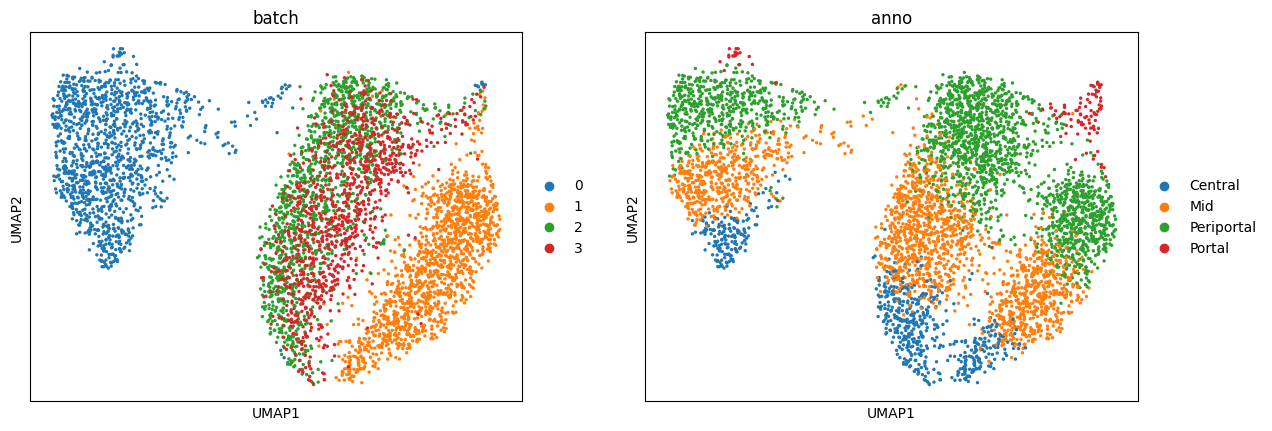

In [6]:
sc.pl.umap(allst,color=['batch','anno'])

In [5]:
scdata = pd.DataFrame(scadata.X.todense(),index=scadata.obs_names,columns=scadata.var_names)
stdata = pd.DataFrame(stadata.X.todense(),index=stadata.obs_names,columns=stadata.var_names)
stdata2 = pd.DataFrame(stadata2.X.todense(),index=stadata2.obs_names,columns=stadata2.var_names)
stdata3 = pd.DataFrame(stadata3.X.todense(),index=stadata3.obs_names,columns=stadata3.var_names)
stdata4 = pd.DataFrame(stadata4.X.todense(),index=stadata4.obs_names,columns=stadata4.var_names)

In [6]:
sc.pp.calculate_qc_metrics(scadata,percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(stadata,percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(stadata2,percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(stadata3,percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(stadata4,percent_top=None, log1p=False, inplace=True)

dp1 = 1 - scadata.obs['n_genes_by_counts'].median()/stadata.obs['n_genes_by_counts'].median()
dp2 = 1 - scadata.obs['n_genes_by_counts'].median()/stadata2.obs['n_genes_by_counts'].median()
dp3 = 1 - scadata.obs['n_genes_by_counts'].median()/stadata3.obs['n_genes_by_counts'].median()
dp4 = 1 - scadata.obs['n_genes_by_counts'].median()/stadata4.obs['n_genes_by_counts'].median()

dp = np.mean([dp1,dp2,dp3,dp4])
dp

0.5439218636030667

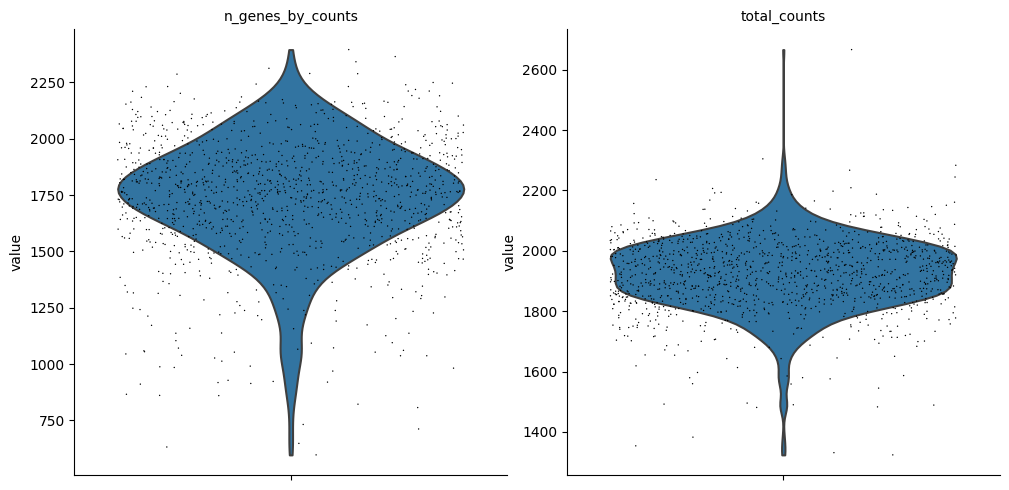

In [7]:
figsize(6,3)
sc.pl.violin(stadata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

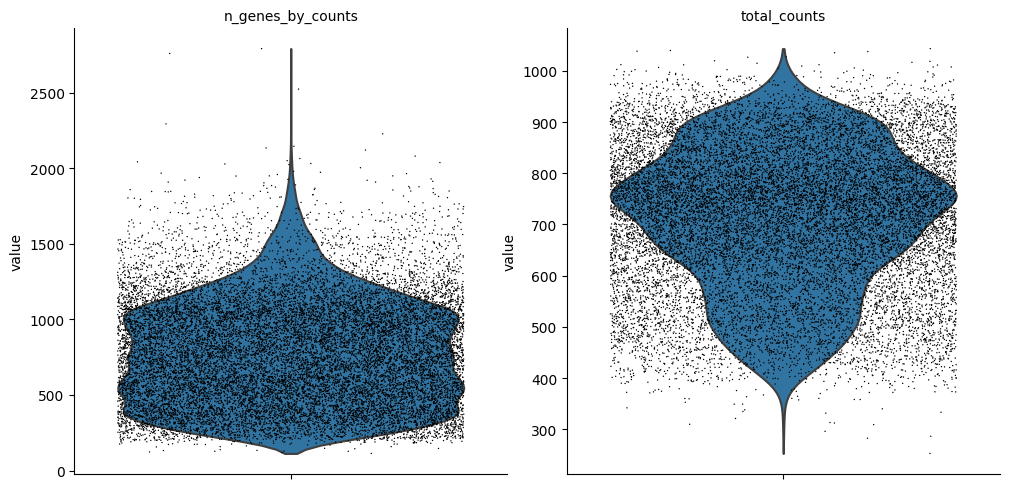

In [8]:
sc.pl.violin(scadata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

In [9]:
seed_value=42
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

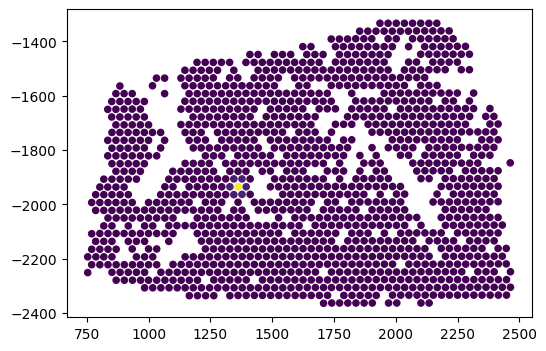

In [10]:
spcoor = stadata.obsm['spatial']

figsize(6,4)
st_neighbor = scipy.spatial.distance.cdist(spcoor,spcoor)
sigma = 15
st_neighbor = np.exp(-st_neighbor**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
plt.scatter(spcoor[:,0],-spcoor[:,1],c=np.expm1(st_neighbor[500,:]),s=20)

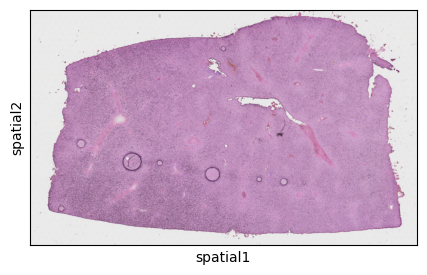

In [11]:
figsize(5,5)
sc.pl.spatial(stadata)

In [12]:
from torch.utils.data import DataLoader, Dataset
class STData(Dataset):
    def __init__(self,data,coord):
        self.data = data
        self.coord = coord

    def __getitem__(self, index):
        return self.data[index], self.coord[index]
    
    def __len__(self):
        return self.data.shape[0]

class SCData(Dataset):
    def __init__(self,data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.data.shape[0]

In [13]:
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
class FeatureNet(nn.Module):
    def __init__(self, n_genes, n_embedding=[512,256,128]):
        super(FeatureNet, self).__init__()

        self.fc1 = nn.Linear(n_genes, n_embedding[0])
        self.bn1 = nn.LayerNorm(n_embedding[0])
        self.fc2 = nn.Linear(n_embedding[0], n_embedding[1])
        self.bn2 = nn.LayerNorm(n_embedding[1])
        self.fc3 = nn.Linear(n_embedding[1], n_embedding[2])

    def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [14]:
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
class FeatureNet(nn.Module):
    def __init__(self, n_genes, n_embedding=[512,256,128]):
        super(FeatureNet, self).__init__()

        self.fc1 = nn.Linear(n_genes, n_embedding[0])
        self.bn1 = nn.LayerNorm(n_embedding[0])
        self.fc2 = nn.Linear(n_embedding[0], n_embedding[1])
        self.bn2 = nn.LayerNorm(n_embedding[1])
        self.fc3 = nn.Linear(n_embedding[1], n_embedding[2])
        
        ## 多加的
        self.dp = nn.Dropout(dp)
        
    def forward(self, x,isdp = False):
        if isdp:
            x = self.dp(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.optim.lr_scheduler as lr_scheduler
class BaseModel(nn.Module):
    def __init__(self, opt):
        super(BaseModel, self).__init__()
        self.opt = opt
        self.device = opt.device

        self.train_log = opt.outf + '/train.log'
        self.model_path = opt.outf + '/model.pth'
        if not os.path.exists(opt.outf):
            os.mkdir(opt.outf)
        self.best_acc_tgt = 0
        
        with open(self.train_log, 'a') as f:
            localtime = time.asctime( time.localtime(time.time()) )
            f.write(localtime+str((opt.device,opt.outf,opt.n_genes,opt.no_bn,opt.lr,opt.sigma,opt.alpha,opt.verbose))+'\n')

        # print('source domain', self.domain_mask == 1)
        # print('target domain', self.domain_mask == 0)

        self.tsne = TSNE(n_components=2)
        self.pca = PCA(n_components=2)

    #         self.wgan = opt.wgan if opt.wgan is not None else False

    def set_requires_grad(self, nets, requires_grad=False):
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

            
        
    
    def forward(self):
        self.e_seq = self.netE(self.x_seq, self.t_seq)  # encoder of the data
        self.f_seq = self.netF(self.e_seq)  # logit of the prediction
        self.g_seq = torch.argmax(self.f_seq.detach(), dim=2)  # class of the prediction

    def optimize_parameters(self):
        self.forward()  # forward prediction
        # update the discriminator D (optional)
        self.set_requires_grad(self.netD, True)
        self.optimizer_D.zero_grad()
        self.backward_D()
        self.optimizer_D.step()

        # update the encoder E and predictor F
        self.set_requires_grad(self.netD, False)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()

    def learn(self, epoch, dataloader):
        self.epoch = epoch

        self.train()

        loss_curve = {
            loss: []
            for loss in self.loss_names
        }
        acc_curve = []

        for data in dataloader:
            x_seq, y_seq = [d[0][None, :, :] for d in data], [d[1][None, :] for d in data]
            x_seq = torch.cat(x_seq, 0).to(self.device)
            y_seq = torch.cat(y_seq, 0).to(self.device)

            self.set_input(input=(x_seq, y_seq))
            self.optimize_parameters()

            for loss in self.loss_names:
                loss_curve[loss].append(getattr(self, 'loss_' + loss).item())

            acc_curve.append(self.g_seq.eq(self.y_seq).to(torch.float).mean(-1, keepdim=True))

        loss_msg = '[Train][{}] Loss:'.format(epoch)
        for loss in self.loss_names:
            loss_msg += ' {} {:.3f}'.format(loss, np.mean(loss_curve[loss]))

        acc = to_np(torch.cat(acc_curve, 1).mean(-1))
        acc_msg = '[Train][{}] Accuracy: total average {:.1f}, in each domain {}'.format(epoch, acc.mean() * 100, np.around(acc * 100, decimals=1))

        if (epoch + 1) % 10 == 0:
            print(loss_msg)
            print(acc_msg)
        with open(self.train_log, 'a') as f:
            f.write(loss_msg + "\n" + acc_msg + "\n")
        for lr_scheduler in self.lr_schedulers:
            lr_scheduler.step()

    def save(self):
        torch.save(self.state_dict(), self.model_path)

    def load(self):
        print('===> Loading model from {}'.format(self.model_path))
        try:
            self.load_state_dict(torch.load(self.model_path))
            print('<=== Success!')
        except:
            print('<==== Failed!')

    def set_data_stats(self, dm, ds):
        self.data_m, self.data_s = dm, ds

    def init_weight(self, net=None):
        if net is None:
            net = self
        for m in net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.xavier_normal_(m.weight, gain=10)
                nn.init.constant_(m.bias, val=0)

In [16]:
import torch
import torch.nn as nn
class MMDLoss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5, fix_sigma=None, **kwargs):
        super(MMDLoss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul, kernel_num, fix_sigma):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        tmp = 0
        for x in kernel_val:
            tmp += x
        return tmp
#         print(kernel_val.shape)
#         return kernel_val
    

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss

In [17]:
class SOmodel(BaseModel):
    def __init__(self, opt):
        super(SOmodel, self).__init__(opt)
        self.netE = FeatureNet(opt.n_genes)
        self.optimizer_G = torch.optim.AdamW(self.netE.parameters(), lr=opt.lr)
        self.lr_scheduler = lr_scheduler.StepLR(optimizer=self.optimizer_G,step_size=200, gamma=0.5)
        self.loss_names = ['E','E_pred','E_circle','E_mmd']
        self.mmd_fn = MMDLoss()
        self.sigma = opt.sigma
        self.alpha = opt.alpha
        self.verbose = opt.verbose
        
        
    def train_onestep(self,stdata,scdata,coord,ratio):
                
        self.optimizer_G.zero_grad()
        if self.sigma == 0:
            self.nettrue = torch.eye(coord.shape[0])
        else:
            self.nettrue = torch.tensor(scipy.spatial.distance.cdist(coord,coord)).to(torch.float32)
            sigma = self.sigma
            self.nettrue = torch.exp(-self.nettrue**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
            self.nettrue = F.normalize(self.nettrue,p=1,dim=1)
        self.nettrue = self.nettrue.to(self.device)
        stdata = stdata.to(self.device)
        scdata = scdata.to(self.device)
        self.e_seq_st = self.netE(stdata,True)
        # self.e_seq_st = torch.utils.checkpoint.checkpoint(self.netE,stdata,True)
        self.e_seq_sc = self.netE(scdata,False)
        # self.e_seq_sc = torch.utils.checkpoint.checkpoint(self.netE,scdata,False)
        
        self.netpred = self.e_seq_st.mm(self.e_seq_st.t())
        self.st2sc = F.softmax(self.e_seq_st.mm(self.e_seq_sc.t()),dim=1)
        self.sc2st = F.softmax(self.e_seq_sc.mm(self.e_seq_st.t()),dim=1)
        
        self.st2st = torch.log(self.st2sc.mm(self.sc2st)+1e-7)
        
        self.loss_E_pred = F.cross_entropy(self.netpred, self.nettrue,reduction='mean')
        
        self.loss_E_circle = F.kl_div(self.st2st,self.nettrue,reduction='none').sum(1).mean()
        
        ranidx = np.random.randint(0,self.e_seq_sc.shape[0],1000)
#         self.loss_E_mmd = torch.tensor(0)
        
        self.loss_E_mmd = self.mmd_fn(self.e_seq_st,self.e_seq_sc[ranidx])
        
        self.loss_E = self.loss_E_pred + self.alpha*self.loss_E_mmd + ratio*self.loss_E_circle
#         self.loss_E = self.loss_E_pred + self.alpha*ratio*self.loss_E_circle
        self.loss_E.backward()
        self.optimizer_G.step()
        
    def togpu(self):
        self.netE.to(self.device)

    def modeleval(self):
        self.netE.eval()
        
    def train(self,epoch,scdataloader,stdata,coord):
        with open(self.train_log, 'a') as f:
            localtime = time.asctime( time.localtime(time.time()) )
            f.write(localtime+'\n')
        
        loss_curve = {
            loss: []
            for loss in self.loss_names
        }
        for i in range(epoch):
            self.netE.train()
            for batch_idx, (scdata) in enumerate(scdataloader):
                scdata = scdata.to(torch.float32)
#                 ridx = np.random.randint(0,stdata.shape[0],scdata.shape[0])
#                 train_stdata = stdata[ridx,:]
                self.train_onestep(stdata,scdata,coord,max((i-50)/(epoch-50),0))   
                for loss in self.loss_names:
                    loss_curve[loss].append(getattr(self, 'loss_' + loss).item())
                    
            self.lr_scheduler.step()
            loss_msg = '[Train][{}] Loss:'.format(i+1)
            for loss in self.loss_names:
                loss_msg += ' {} {:.3f}'.format(loss, loss_curve[loss][-1])
            if (i + 1) % 1 == 0:
                print(loss_msg)
                print(self.lr_scheduler.get_last_lr())
            with open(self.train_log, 'a') as f:
                f.write(loss_msg + "\n")
        return loss_curve
    
    
    def train_spatialbatch(self,epoch,scdata,stdataloader):
        with open(self.train_log, 'a') as f:
            localtime = time.asctime( time.localtime(time.time()) )
            f.write(localtime+'\n')
        
        loss_curve = {
            loss: []
            for loss in self.loss_names
        }
        for i in range(epoch):
            self.netE.train()
            for batch_idx, (stdata,coord) in enumerate(stdataloader):
                stdata = stdata.to(torch.float32)
                self.train_onestep(stdata,scdata,coord,max((i-50)/(epoch-50),0))   
                for loss in self.loss_names:
                    loss_curve[loss].append(getattr(self, 'loss_' + loss).item())
                    
            self.lr_scheduler.step()
            loss_msg = '[Train][{}] Loss:'.format(i+1)
            for loss in self.loss_names:
                loss_msg += ' {} {:.3f}'.format(loss, loss_curve[loss][-1])
            if (i + 1) % 1 == 0:
                print(loss_msg)
                print(self.lr_scheduler.get_last_lr())
            with open(self.train_log, 'a') as f:
                f.write(loss_msg + "\n")
        return loss_curve
    
    def train_wholedata(self,epoch,scdata,stdata,coord):
        with open(self.train_log, 'a') as f:
            localtime = time.asctime( time.localtime(time.time()) )
            f.write(localtime+'\n')
        
        loss_curve = {
            loss: []
            for loss in self.loss_names
        }
        for i in range(epoch):
            self.netE.train()
            scdata = scdata.to(torch.float32)
            if isinstance(stdata,list):
                shuffle_list = randint(0,len(stdata),len(stdata))
                for idx in shuffle_list:
                    self.train_onestep(stdata[idx],scdata,coord[idx],max((i-50)/(epoch-50),0))
            else:
                self.train_onestep(stdata,scdata,coord,max((i-50)/(epoch-50),0)) 
            
            for loss in self.loss_names:
                loss_curve[loss].append(getattr(self, 'loss_' + loss).item())
                    
            self.lr_scheduler.step()
            loss_msg = '[Train][{}] Loss:'.format(i)
            for loss in self.loss_names:
                loss_msg += ' {} {:.3f}'.format(loss, loss_curve[loss][-1])
            if (i + 1) % 1 == 0:
                if self.verbose:
                    print(loss_msg)
                    print(self.lr_scheduler.get_last_lr())
            with open(self.train_log, 'a') as f:
                f.write(loss_msg + "\n")
        return loss_curve

In [18]:
class setting( object ):
    pass
opt= setting()
setattr(opt, 'device', 'cuda:0')
setattr(opt, 'outf', '../../log/0302_Liver_multiple_withnewsc_readsave')
setattr(opt, 'n_genes', stdata.shape[1])
setattr(opt, 'no_bn', False)
setattr(opt, 'lr', 0.002)
setattr(opt, 'sigma', 13)
setattr(opt, 'alpha', 0.8)
setattr(opt, 'verbose', True)

In [19]:
spcoor = pd.DataFrame(stadata.obsm['spatial'],index=stadata.obs_names.tolist(),columns=['xcoord','ycoord'])
spcoor2 = pd.DataFrame(stadata2.obsm['spatial'],index=stadata2.obs_names.tolist(),columns=['xcoord','ycoord'])
spcoor3 = pd.DataFrame(stadata3.obsm['spatial'],index=stadata3.obs_names.tolist(),columns=['xcoord','ycoord'])
spcoor4 = pd.DataFrame(stadata4.obsm['spatial'],index=stadata4.obs_names.tolist(),columns=['xcoord','ycoord'])


scdataset = SCData(data=scdata.values)
batch_size = 1024

spcoor_list = [
    torch.tensor(spcoor.values).float(),
    torch.tensor(spcoor2.values).float(),
    torch.tensor(spcoor3.values).float(),
    torch.tensor(spcoor4.values).float(),
]
stdata_list = [
    torch.tensor(stdata.values).float(),
    torch.tensor(stdata2.values).float(),
    torch.tensor(stdata3.values).float(),
    torch.tensor(stdata4.values).float(),
]

stdataset = STData(data=stdata.values,coord=spcoor.values)
# stdataloader = DataLoader(stdataset, batch_size=batch_size, shuffle=True)

In [20]:
import torch.utils.checkpoint
testmodel =  SOmodel(opt)
testmodel.togpu()
# loss_curve = testmodel.train_wholedata(1000,torch.tensor(scdata.values).float(),stdata_list,spcoor_list)
# loss_curve = testmodel.train_spatialbatch(1000,torch.tensor(scdata.values).float(),stdataloader)

In [24]:
testmodel.model_path='../../log/0302_Liver_multiple_withnewsc/model.pth'
testmodel.load()

===> Loading model from ../../log/0302_Liver_multiple_withnewsc/model.pth
<=== Success!


In [25]:
def all_coord(mappingmtx,spcoor):
    mappingnorm = mappingmtx.div(mappingmtx.sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.xcoord.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.ycoord.values)
    return spaotsc_coord

def k_coord(mappingmtx,spcoor, k=1):
    maskmap = np.zeros_like(mappingmtx)

    argmask = np.argsort(1/(mappingmtx.values+1e-15),axis=1)

    for i in range(argmask.shape[0]):
        for j in range(k):
            maskmap[i,argmask[i,j]]=1

    mappingnorm = (maskmap*mappingmtx).div((maskmap*mappingmtx).sum(axis=1)+1e-15, axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.xcoord.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.ycoord.values)
    return spaotsc_coord

In [26]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netst2sc = pd.DataFrame(netst2sc,index=stdata.index,columns=scdata.index)
netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata.index)
scadata.obsm['spatialDA'] = k_coord(netsc2st,spcoor,5)
scadata.obsm['spatialDAall'] = all_coord(netsc2st,spcoor)

In [27]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata2.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netst2sc = pd.DataFrame(netst2sc,index=stdata2.index,columns=scdata.index)
netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata2.index)
scadata.obsm['spatialDA2'] = k_coord(netsc2st,spcoor2,5)
scadata.obsm['spatialDAall2'] = all_coord(netsc2st,spcoor2)

In [28]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata3.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netst2sc = pd.DataFrame(netst2sc,index=stdata3.index,columns=scdata.index)
netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata3.index)
scadata.obsm['spatialDA3'] = k_coord(netsc2st,spcoor3,5)
scadata.obsm['spatialDAall3'] = all_coord(netsc2st,spcoor3)

In [29]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata4.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netst2sc = pd.DataFrame(netst2sc,index=stdata4.index,columns=scdata.index)
netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata4.index)
scadata.obsm['spatialDA4'] = k_coord(netsc2st,spcoor4,5)
scadata.obsm['spatialDAall4'] = all_coord(netsc2st,spcoor4)

In [30]:
def getpesudospace(stadata,stdata,scadata,testmodel):
    stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
    netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
    netsc2st = pd.DataFrame(netsc2st,index=scdata.index,columns=stdata.index)
    assert netsc2st.index.tolist() == scadata.obs_names.tolist()
    return netsc2st.values @ stadata.obs['zonation'].values
scadata.obs['pseudospace'] = getpesudospace(stadata,stdata,scadata,testmodel)
scadata.obs['pseudospace2'] = getpesudospace(stadata2,stdata2,scadata,testmodel)
scadata.obs['pseudospace3'] = getpesudospace(stadata3,stdata3,scadata,testmodel)
scadata.obs['pseudospace4'] = getpesudospace(stadata4,stdata4,scadata,testmodel)

In [31]:
calscadata = scadata.copy()

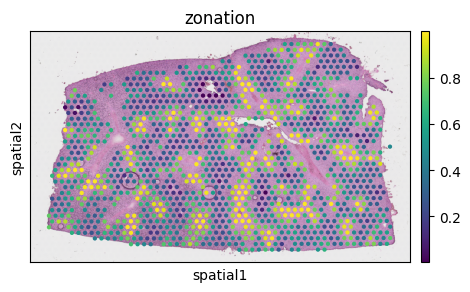

In [37]:
sc.settings.figdir='../../result_liver_0711rep/'
sc.pl.spatial(stadata,color='zonation',save='zonationsocre')

In [41]:
merged_pseudospace = calscadata.obs[['pseudospace','pseudospace2','pseudospace3','pseudospace4']].mean(1)
calscadata.obs['merged_pseudospace'] = merged_pseudospace

In [43]:
rawscadata =  sc.read_h5ad('single-cell/mousescnew.h5ad')
rawscadata.obsm = calscadata.obsm
rawscadata.obs = calscadata.obs

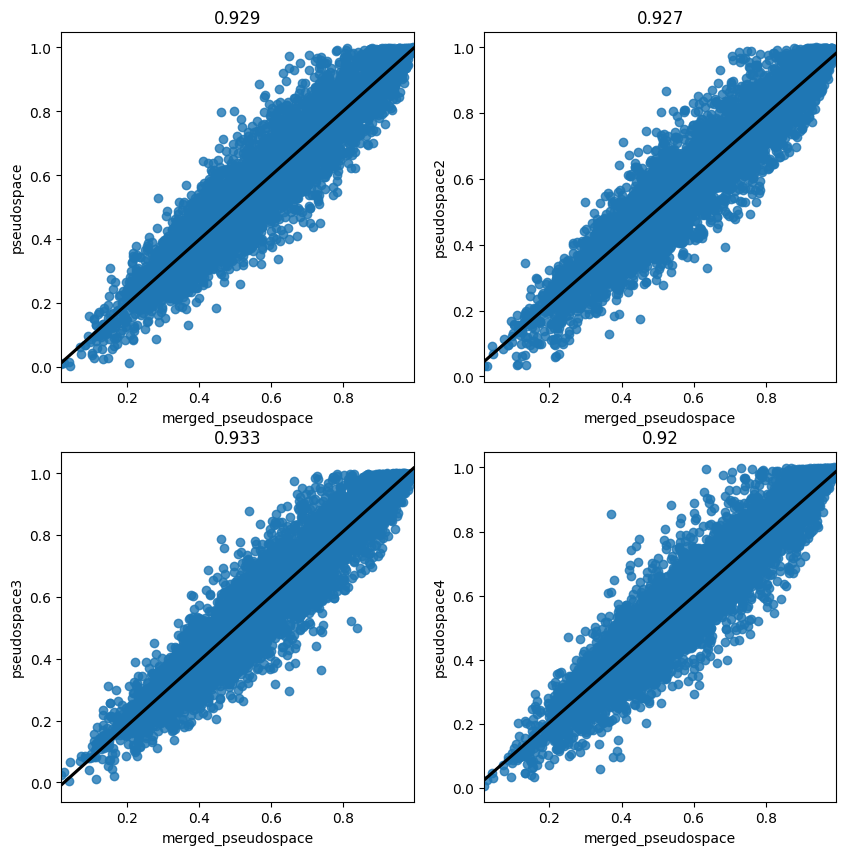

In [46]:
import seaborn as sns
from scipy import stats
figsize(10,10)
f,ax = plt.subplots(2,2)
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.regplot(x=calscadata.obs['merged_pseudospace'],y=calscadata.obs['pseudospace'],line_kws={'color':'black'},ax=ax[0][0])
sns.regplot(x=calscadata.obs['merged_pseudospace'],y=calscadata.obs['pseudospace2'],line_kws={'color':'black'},ax=ax[0][1])
sns.regplot(x=calscadata.obs['merged_pseudospace'],y=calscadata.obs['pseudospace3'],line_kws={'color':'black'},ax=ax[1][0])
sns.regplot(x=calscadata.obs['merged_pseudospace'],y=calscadata.obs['pseudospace4'],line_kws={'color':'black'},ax=ax[1][1])
ax[0][0].title.set_text(np.round(r2(calscadata.obs['merged_pseudospace'],calscadata.obs['pseudospace']),3));
ax[0][1].title.set_text(np.round(r2(calscadata.obs['merged_pseudospace'],calscadata.obs['pseudospace2']),3));
ax[1][0].title.set_text(np.round(r2(calscadata.obs['merged_pseudospace'],calscadata.obs['pseudospace3']),3));
ax[1][1].title.set_text(np.round(r2(calscadata.obs['merged_pseudospace'],calscadata.obs['pseudospace4']),3));

# Cell type trajectory

## All Hepatocytes

In [47]:
nucadata = rawscadata

In [48]:
hepadata = rawscadata[rawscadata.obs.annot=='Hepatocytes'].copy()
hepadata = hepadata[:,stadata.var_names].copy()
sc.pp.normalize_total(hepadata)
sc.pp.log1p(hepadata)

def getpesudospace(stadata,stdata,scadata,scdata,testmodel):
    stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
    scembedding = testmodel.netE(torch.tensor(scdata,dtype=torch.float32).cuda())
    netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
    netsc2st = pd.DataFrame(netsc2st,index=scadata.obs_names.tolist(),columns=stdata.index)
    assert netsc2st.index.tolist() == scadata.obs_names.tolist()
    return netsc2st.values @ stadata.obs['zonation'].values

hepadata.obs['pseudospace'] = getpesudospace(stadata,stdata,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace2'] = getpesudospace(stadata2,stdata2,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace3'] = getpesudospace(stadata3,stdata3,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace4'] = getpesudospace(stadata4,stdata4,hepadata,hepadata.X.todense(),testmodel)
merged_pseudospace = hepadata.obs[['pseudospace','pseudospace2','pseudospace3','pseudospace4']].mean(1)

In [49]:
cahepadata = rawscadata[rawscadata.obs.annot=='Hepatocytes'].copy()
cahepadata = cahepadata[:,stadata.var_names].copy()
sc.pp.normalize_total(cahepadata)
sc.pp.log1p(cahepadata)

testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(cahepadata.X.todense(),dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = pd.DataFrame(netsc2st,index=cahepadata.obs_names,columns=stdata.index)
spcoor1 = k_coord(netsc2st,spcoor,5)

In [50]:
hepadata = nucadata[nucadata.obs.annot=='Hepatocytes'].copy()
hepadata.obs['merged_pseudospace'] = merged_pseudospace
hepadata.obsm['spatialDA'] = spcoor1

In [51]:
hepadata.uns['spatial'] = stadata.uns['spatial']

In [53]:
sc.pp.filter_genes(hepadata,min_cells=10)
sc.pp.normalize_total(hepadata)
sc.pp.log1p(hepadata)
sc.pp.highly_variable_genes(hepadata)
hepadata.raw = hepadata
sc.pp.scale(hepadata)

In [54]:
newobsm = np.concatenate([hepadata.obs.merged_pseudospace.values.reshape(-1,1),np.ones([hepadata.shape[0],1])],axis=1)
hepadata.obsm['space']=newobsm
sc.pp.neighbors(hepadata,use_rep='space')

In [55]:
hepadata.obs['name']='0'
for Qt in np.arange(10,100,10):
    print(Qt)
    Q1 = np.percentile(hepadata.obs['merged_pseudospace'],Qt)
    Q2 = np.percentile(hepadata.obs['merged_pseudospace'],Qt+10)
    hepadata.obs.loc[(hepadata.obs['merged_pseudospace']>=Q1)&(hepadata.obs['merged_pseudospace']<Q2),'name']=str(int(Qt/10))
hepadata.obs['name'] = hepadata.obs['name'].astype('category')

10
20
30
40
50
60
70
80
90


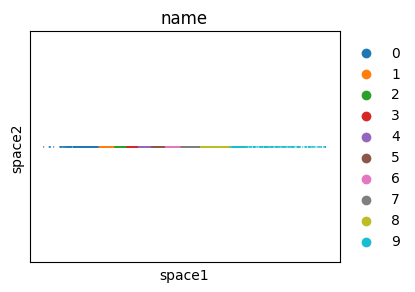

In [56]:
figsize(4,3)
sc.pl.embedding(hepadata,color=['name'],basis='space',s=4)

In [59]:
hepadata.write_h5ad('hepadata0711.h5ad')

In [875]:
sc.tl.rank_genes_groups(hepadata,groupby='name',method='wilcoxon',pts=True)

In [876]:
# hepadata.write('Liver_mouse_sample1_Hep_all.h5ad')
# hepadata = sc.read_h5ad('Liver_mouse_sample1_Hep_all.h5ad')

In [862]:
dedf = sc.get.rank_genes_groups_df(hepadata, group=None,log2fc_min=0,pval_cutoff=0.05)
dedf.names.unique().shape

(819,)

In [877]:
rkgene = pd.DataFrame(hepadata.uns['rank_genes_groups']['names'])
N=3
topgenelist = []
reclusterindex = np.arange(10)
for i in reclusterindex:
    topgenelist += rkgene.iloc[:N,i].tolist()

spa_plotgenelist=[]
for x in topgenelist:
    if x not in spa_plotgenelist:
        spa_plotgenelist.append(x)

In [893]:
import colorbm as cbm

In [895]:
cbm.seq('gsea').as_cmap

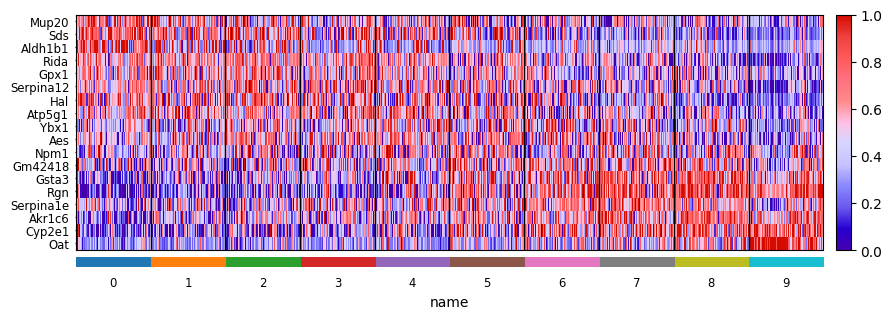

In [896]:
rcParams['axes.spines.right'] = True
rcParams['axes.spines.top'] = True
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
cellrank = hepadata.obs['merged_pseudospace'].sort_values().index
sc.pl.heatmap(hepadata[cellrank,:],var_names=spa_plotgenelist,groupby='name',cmap=cbm.seq('gsea').as_cmap,standard_scale ='obs',swap_axes=True,use_raw=False,save='hepheatmap.pdf')

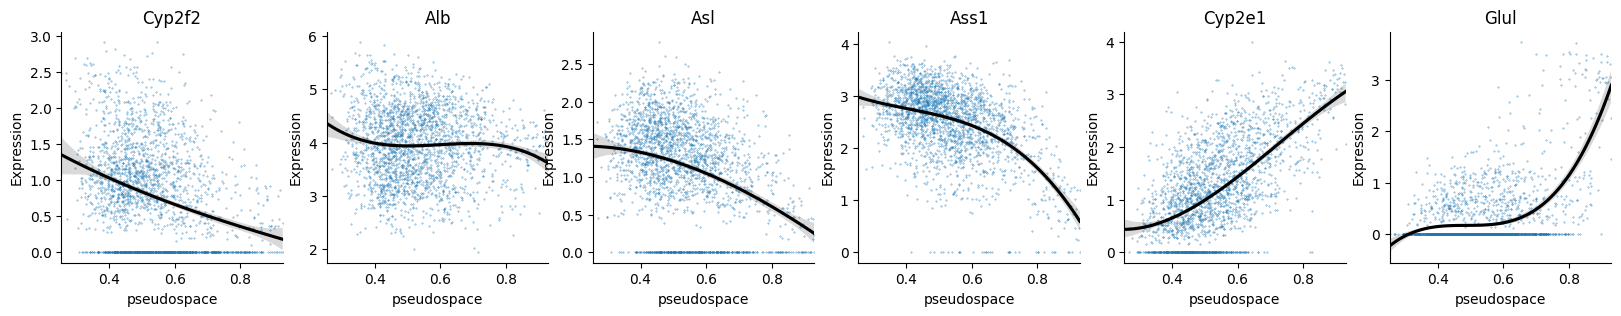

In [813]:
figsize(20,3)
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
f, ax = plt.subplots(1,6)
df = sc.get.rank_genes_groups_df(hepadata, group="0",log2fc_min=0,pval_cutoff=0.05)
genelist=['Cyp2f2','Alb','Asl','Ass1','Cyp2e1','Glul']
# genelist = ['Cyp2f2']
genedf =pd.DataFrame(hepadata.raw[:,genelist].X.toarray(),index = hepadata.obs_names,columns=genelist)
genedf['pseudospace']=hepadata.obs.merged_pseudospace
for i in range(6):
    gn = genelist[i]
    sns.regplot(data=genedf,x='pseudospace',y=gn,order=3,scatter_kws=dict(s=0.1),line_kws=dict(color='black'),label=gn,ax=ax[i])
    ax[i].title.set_text(gn)
    ax[i].set_ylabel('Expression')
plt.savefig('../../result_liver/mkgenetrj.pdf',bbox_inches='tight')

## Fibroblasts

In [897]:
tmpnucadata = nucadata.copy()
sc.pp.normalize_total(tmpnucadata)
sc.pp.log1p(tmpnucadata)
hepadata = tmpnucadata[tmpnucadata.obs.annot=='Fibroblasts'].copy()
hepadata = hepadata[:,stadata.var_names].copy()


def getpesudospace(stadata,stdata,scadata,scdata,testmodel):
    stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
    scembedding = testmodel.netE(torch.tensor(scdata,dtype=torch.float32).cuda())
    netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
    netsc2st = pd.DataFrame(netsc2st,index=scadata.obs_names.tolist(),columns=stdata.index)
    assert netsc2st.index.tolist() == scadata.obs_names.tolist()
    return netsc2st.values @ stadata.obs['zonation'].values

hepadata.obs['pseudospace'] = getpesudospace(stadata,stdata,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace2'] = getpesudospace(stadata2,stdata2,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace3'] = getpesudospace(stadata3,stdata3,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace4'] = getpesudospace(stadata4,stdata4,hepadata,hepadata.X.todense(),testmodel)
merged_pseudospace = hepadata.obs[['pseudospace','pseudospace2','pseudospace3','pseudospace4']].mean(1)

In [898]:
tmpnucadata = nucadata.copy()
sc.pp.normalize_total(tmpnucadata)
sc.pp.log1p(tmpnucadata)
cahepadata = tmpnucadata[tmpnucadata.obs.annot=='Fibroblasts'].copy()
cahepadata = cahepadata[:,stadata.var_names].copy()


testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(cahepadata.X.toarray(),dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = pd.DataFrame(netsc2st,index=cahepadata.obs_names,columns=stdata.index)
spcoor1 = k_coord(netsc2st,spcoor,1)
spcoorall = all_coord(netsc2st,spcoor)
spcoor5 = k_coord(netsc2st,spcoor,5)

In [900]:
hepadata = nucadata[nucadata.obs.annot=='Fibroblasts'].copy()
hepadata.obs['merged_pseudospace'] = merged_pseudospace
hepadata.obsm['spatialDA'] = spcoor5
hepadata.obsm['spatialDAall'] = spcoorall

In [901]:
sc.pp.filter_genes(hepadata,min_cells=10)
sc.pp.normalize_total(hepadata)
sc.pp.log1p(hepadata)
sc.pp.highly_variable_genes(hepadata)
hepadata.raw = hepadata
sc.pp.scale(hepadata)

In [902]:
hepadata.uns['spatial'] = stadata.uns['spatial']

In [904]:
newobsm = np.concatenate([hepadata.obs.merged_pseudospace.values.reshape(-1,1),np.ones([hepadata.shape[0],1])],axis=1)
hepadata.obsm['space']=newobsm
sc.pp.neighbors(hepadata,use_rep='space')

### DE

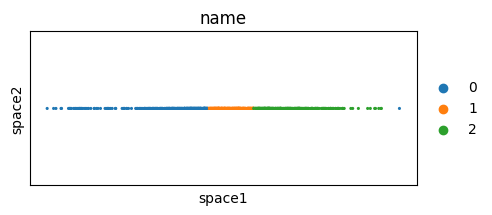

In [905]:
hepadata.obs['name']='0'
Qtlist = [1/3*100,2/3*100]

inter = Qtlist[1] - Qtlist[0]
for i in range(len(Qtlist)):
    Qt = Qtlist[i]
    Q1 = np.percentile(hepadata.obs['merged_pseudospace'],Qt)
    Q2 = np.percentile(hepadata.obs['merged_pseudospace'],Qt+inter)
    hepadata.obs.loc[(hepadata.obs['merged_pseudospace']>=Q1)&(hepadata.obs['merged_pseudospace']<Q2),'name']=str(int(i+1))
hepadata.obs['name'] = hepadata.obs['name'].astype('category')

figsize(5,2)
sc.pl.embedding(hepadata,color=['name'],basis='space',s=20)

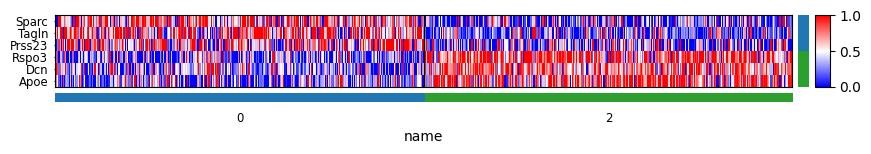

In [906]:
dehepadata = hepadata[hepadata.obs.name.isin(['0','2'])].copy()
sc.tl.rank_genes_groups(dehepadata,groupby='name', method='wilcoxon',pts=True)

sc.pl.rank_genes_groups_heatmap(dehepadata,cmap='bwr',standard_scale ='obs',dendrogram=False,swap_axes=True,n_genes=3,use_raw=False)

In [907]:
dedf = sc.get.rank_genes_groups_df(dehepadata, group="0",log2fc_min=0,pval_cutoff=0.05)
dedf

names     scores  logfoldchanges         pvals     pvals_adj  \
0      Sparc  12.161603        0.660240  4.977228e-34  1.991555e-30   
1      Tagln  11.667788        2.634784  1.862027e-31  3.725296e-28   
2     Prss23   9.941504        1.369192  2.746513e-23  4.121142e-20   
3     Pcolce   8.955321        0.959976  3.387490e-19  3.388619e-16   
4     Igfbp3   8.395277        1.249553  4.647972e-17  3.985304e-14   
..       ...        ...             ...           ...           ...   
121    Itgb1   3.341429        0.233612  8.334818e-04  4.486599e-02   
122    Ahnak   3.326735        0.451050  8.786986e-04  4.646651e-02   
123   Tubb2a   3.324251        0.868894  8.865620e-04  4.667671e-02   
124      Dmd   3.316801        0.575925  9.105450e-04  4.773005e-02   
125  Hcfc1r1   3.308936        0.639659  9.365117e-04  4.866618e-02   

     pct_nz_group  pct_nz_reference  
0        1.000000          1.000000  
1        0.713415          0.263804  
2        0.838415          0.610429  
3        0.920732          0.726994  
4        0.850610          0.723926  
..            ...               ...  
121      0.975610          0.950920  
122      0.777439          0.720859  
123      0.393293          0.242331  
124      0.554878          0.420245  
125      0.515244          0.380368  

[126 rows x 7 columns]

In [908]:
dedf = sc.get.rank_genes_groups_df(dehepadata, group="2",log2fc_min=0,pval_cutoff=0.05)
dedf

names     scores  logfoldchanges         pvals     pvals_adj  \
0      Rspo3  13.930522        1.464117  4.133230e-44  4.961529e-40   
1        Dcn  12.187680        0.547968  3.615665e-34  1.991555e-30   
2       Apoe  12.135112        0.773911  6.881604e-34  2.065169e-30   
3      Abcc9  12.004311        1.108335  3.372625e-33  8.096997e-30   
4       Fcna  10.158401        1.216171  3.040213e-24  5.213531e-21   
..       ...        ...             ...           ...           ...   
100    Rbms1   3.360677        0.273662  7.775165e-04  4.223216e-02   
101   Dusp10   3.339567        0.961741  8.390915e-04  4.496632e-02   
102     Cks2   3.336462        0.390433  8.485191e-04  4.513629e-02   
103  Cyp2c29   3.336048        0.758008  8.497835e-04  4.513629e-02   
104    Acaa2   3.315559        0.213708  9.146002e-04  4.773418e-02   

     pct_nz_group  pct_nz_reference  
0        0.981595          0.823171  
1        1.000000          1.000000  
2        1.000000          1.000000  
3        0.993865          0.884146  
4        0.990798          0.856707  
..            ...               ...  
100      0.941718          0.926829  
101      0.346626          0.210366  
102      0.754601          0.685976  
103      0.417178          0.274390  
104      0.923313          0.948171  

[105 rows x 7 columns]

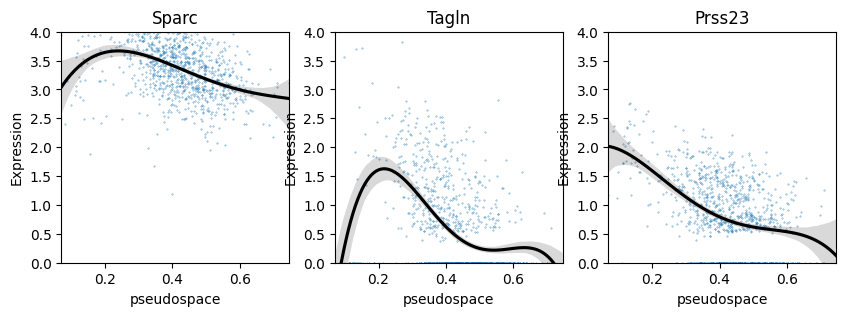

In [909]:
figsize(10,3)
f, ax = plt.subplots(1,3)
df = sc.get.rank_genes_groups_df(dehepadata, group="0",log2fc_min=0,pval_cutoff=0.05)
genelist=df.names[:3].tolist()
genedf =pd.DataFrame(hepadata.raw[:,genelist].X.toarray(),index = hepadata.obs_names,columns=genelist)
genedf['pseudospace']=hepadata.obs.merged_pseudospace
for i in range(3):
    gn = genelist[i]
    sns.regplot(data=genedf,x='pseudospace',y=gn,order=4,scatter_kws=dict(s=0.1),line_kws=dict(color='black'),label=gn,ax=ax[i])
    ax[i].title.set_text(gn)
    ax[i].set_ylim(0,4)
    ax[i].set_ylabel('Expression')

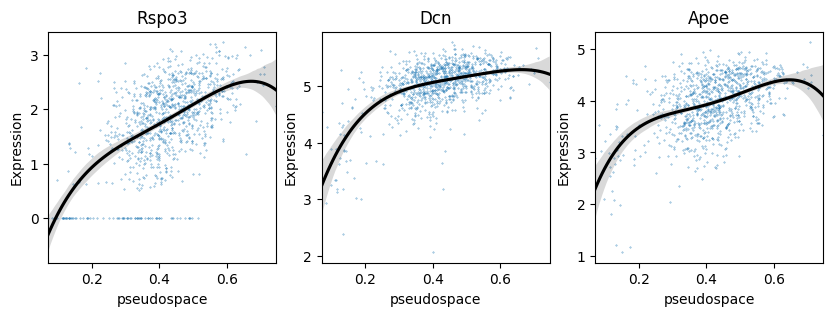

In [910]:
figsize(10,3)
f, ax = plt.subplots(1,3)
df = sc.get.rank_genes_groups_df(dehepadata, group="2",log2fc_min=0,pval_cutoff=0.05)
genelist=df.names[:3].tolist()
genedf =pd.DataFrame(hepadata.raw[:,genelist].X.toarray(),index = hepadata.obs_names,columns=genelist)
genedf['pseudospace']=hepadata.obs.merged_pseudospace
for i in range(3):
    gn = genelist[i]
    sns.regplot(data=genedf,x='pseudospace',y=gn,order=4,scatter_kws=dict(s=0.1),line_kws=dict(color='black'),label=gn,ax=ax[i])
    ax[i].title.set_text(gn)
    ax[i].set_ylabel('Expression')

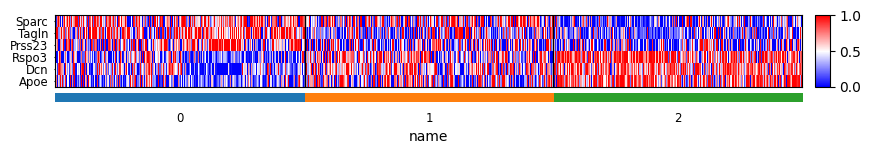

In [911]:
rkgene = pd.DataFrame(dehepadata.uns['rank_genes_groups']['names'])
N=3
topgenelist = []
reclusterindex = [0,1]
for i in reclusterindex:
    topgenelist += rkgene.iloc[:N,i].tolist()

spa_plotgenelist=[]
for x in topgenelist:
    if x not in spa_plotgenelist:
        spa_plotgenelist.append(x)

cellrank = hepadata.obs['merged_pseudospace'].sort_values().index
sc.pl.heatmap(hepadata[cellrank,:],var_names=spa_plotgenelist,groupby='name',cmap='bwr',standard_scale ='obs',swap_axes=True,use_raw=False)

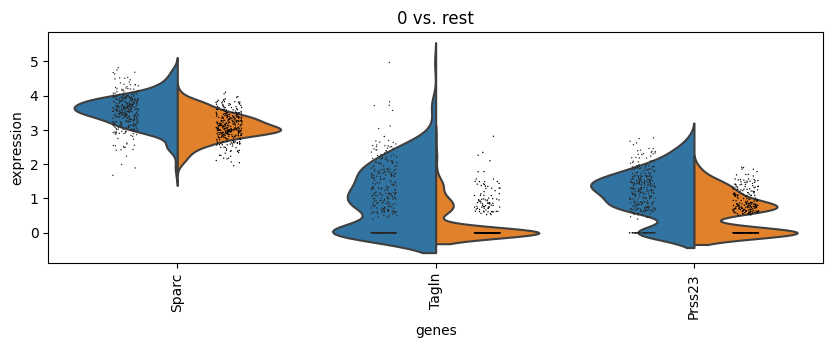

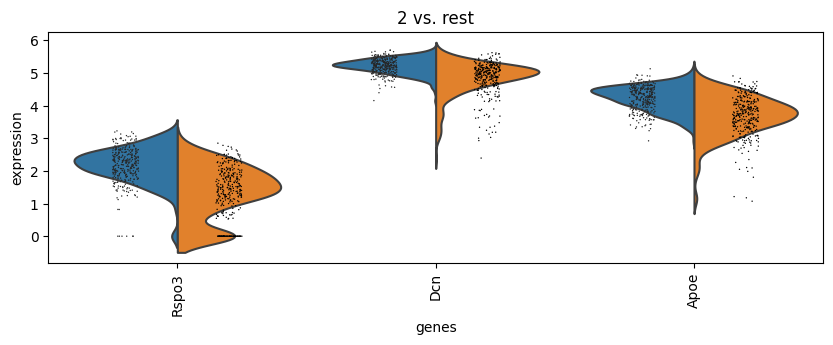

In [912]:
sc.pl.rank_genes_groups_violin(dehepadata,n_genes=3,save='FibroDE')

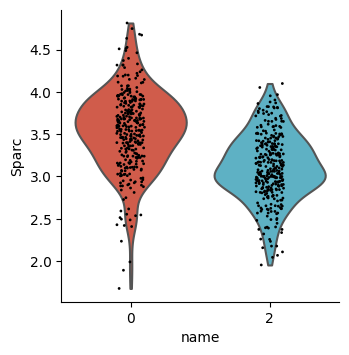

In [927]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(4,4)
sc.pl.violin(dehepadata,keys=['Sparc'],groupby='name',palette=sns.color_palette(cbm.pal('npg').as_hex),size =2,save='Sparc')

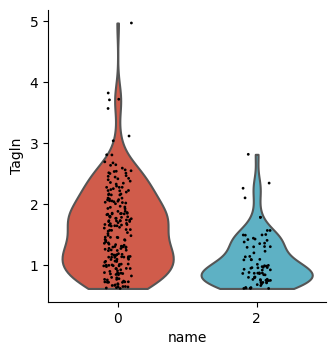

In [944]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(4,4)
tmpadata = dehepadata[:,dehepadata.var_names=='Tagln']
sc.pl.violin(dehepadata[tmpadata.X>0],keys=['Tagln'],groupby='name',palette=sns.color_palette(cbm.pal('npg').as_hex),size =2,save='Tagln')

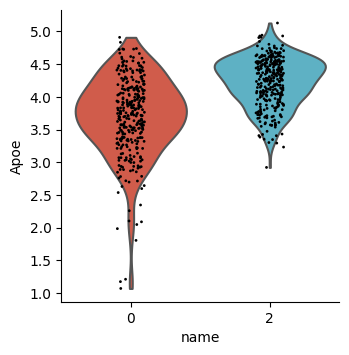

In [997]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(4,4)
G = 'Apoe'
tmpadata = dehepadata.raw.X.toarray()[:,dehepadata.var_names==G]
sc.pl.violin(dehepadata[tmpadata>0],keys=[G],groupby='name',palette=sns.color_palette(cbm.pal('npg').as_hex),size =2,save=G,use_raw=True)

In [918]:
dehepadata

AnnData object with n_obs × n_vars = 654 × 12004
    obs: 'UMAP_1', 'UMAP_2', 'cluster', 'annot', 'sample', 'digest', 'typeSample', 'n_genes_by_counts', 'total_counts', 'pseudospace', 'pseudospace2', 'pseudospace3', 'pseudospace4', 'leiden', 'merged_pseudospace', 'name'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'spatial', 'neighbors', 'name_colors', 'rank_genes_groups'
    obsm: 'Umap_raw', 'spatialDA', 'spatialDAall', 'spatialDA2', 'spatialDAall2', 'spatialDA3', 'spatialDAall3', 'spatialDA4', 'spatialDAall4', 'X_pca', 'X_umap', 'X_oldumap', 'space'
    obsp: 'distances', 'connectivities'

## Endothelial cells

In [815]:
hepadata = nucadata[nucadata.obs.annot=='Endothelial cells'].copy()
hepadata = hepadata[:,stadata.var_names].copy()
sc.pp.normalize_total(hepadata)
sc.pp.log1p(hepadata)

def getpesudospace(stadata,stdata,scadata,scdata,testmodel):
    stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
    scembedding = testmodel.netE(torch.tensor(scdata,dtype=torch.float32).cuda())
    netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
    netsc2st = pd.DataFrame(netsc2st,index=scadata.obs_names.tolist(),columns=stdata.index)
    assert netsc2st.index.tolist() == scadata.obs_names.tolist()
    return netsc2st.values @ stadata.obs['zonation'].values

hepadata.obs['pseudospace'] = getpesudospace(stadata,stdata,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace2'] = getpesudospace(stadata2,stdata2,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace3'] = getpesudospace(stadata3,stdata3,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace4'] = getpesudospace(stadata4,stdata4,hepadata,hepadata.X.todense(),testmodel)
merged_pseudospace = hepadata.obs[['pseudospace','pseudospace2','pseudospace3','pseudospace4']].mean(1)

In [816]:
tmpnucadata = nucadata.copy()
sc.pp.normalize_total(tmpnucadata)
sc.pp.log1p(tmpnucadata)
cahepadata = tmpnucadata[tmpnucadata.obs.annot=='Endothelial cells'].copy()
cahepadata = cahepadata[:,stadata.var_names].copy()


testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(cahepadata.X.toarray(),dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = pd.DataFrame(netsc2st,index=cahepadata.obs_names,columns=stdata.index)
spcoor1 = k_coord(netsc2st,spcoor,1)
spcoorall = all_coord(netsc2st,spcoor)
spcoor5 = k_coord(netsc2st,spcoor,5)

In [817]:
hepadata = nucadata[nucadata.obs.annot=='Endothelial cells'].copy()
hepadata.obs['merged_pseudospace'] = merged_pseudospace
hepadata.obsm['spatialDA'] = spcoor5

In [818]:
sc.pp.filter_genes(hepadata,min_cells=10)
sc.pp.normalize_total(hepadata)
sc.pp.log1p(hepadata)
sc.pp.highly_variable_genes(hepadata)
hepadata.raw = hepadata
sc.pp.scale(hepadata)

In [819]:
hepadata.uns['spatial'] = stadata.uns['spatial']

In [821]:
hepadata.obs['name']='0'
Qtlist = [1/3*100,2/3*100]

inter = Qtlist[1] - Qtlist[0]
for i in range(len(Qtlist)):
    Qt = Qtlist[i]
    Q1 = np.percentile(hepadata.obs['merged_pseudospace'],Qt)
    Q2 = np.percentile(hepadata.obs['merged_pseudospace'],Qt+inter)
    hepadata.obs.loc[(hepadata.obs['merged_pseudospace']>=Q1)&(hepadata.obs['merged_pseudospace']<Q2),'name']=str(int(i+1))
hepadata.obs['name'] = hepadata.obs['name'].astype('category')

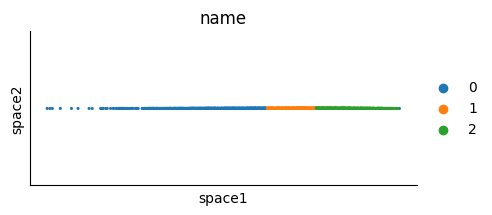

In [822]:
newobsm = np.concatenate([hepadata.obs.merged_pseudospace.values.reshape(-1,1),np.ones([hepadata.shape[0],1])],axis=1)
hepadata.obsm['space']=newobsm
figsize(5,2)
sc.pl.embedding(hepadata,color=['name'],basis='space',s=20)

In [823]:
sc.tl.rank_genes_groups(hepadata,groupby='name',method='wilcoxon',pts=True)

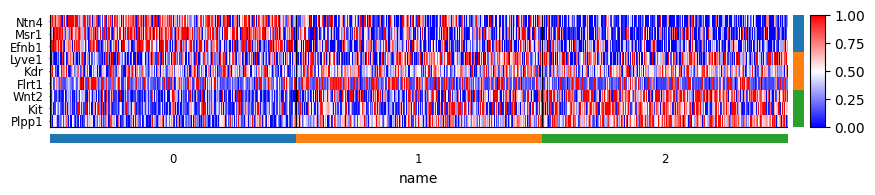

In [824]:
sc.pl.rank_genes_groups_heatmap(hepadata,cmap='bwr',standard_scale ='obs',dendrogram=False,swap_axes=True,n_genes=3,use_raw=False)

In [6]:
# hepadata.write('Liver_mouse_sample1_Endo_all.h5ad')

hepadata = sc.read_h5ad('Liver_mouse_sample1_Endo_all.h5ad')

In [11]:
dedf = sc.get.rank_genes_groups_df(hepadata, group=None,log2fc_min=0)
dedf[dedf.names.isin(['Adgrg6','Gja5'])]

group   names     scores  logfoldchanges         pvals     pvals_adj  \
5       0  Adgrg6  10.115502        2.456872  4.715913e-24  8.132779e-21   
211     0    Gja5   2.742378        2.134895  6.099606e-03  2.223815e-01   

     pct_nz_group  pct_nz_reference  
5        0.338028          0.087877  
211      0.085787          0.016036

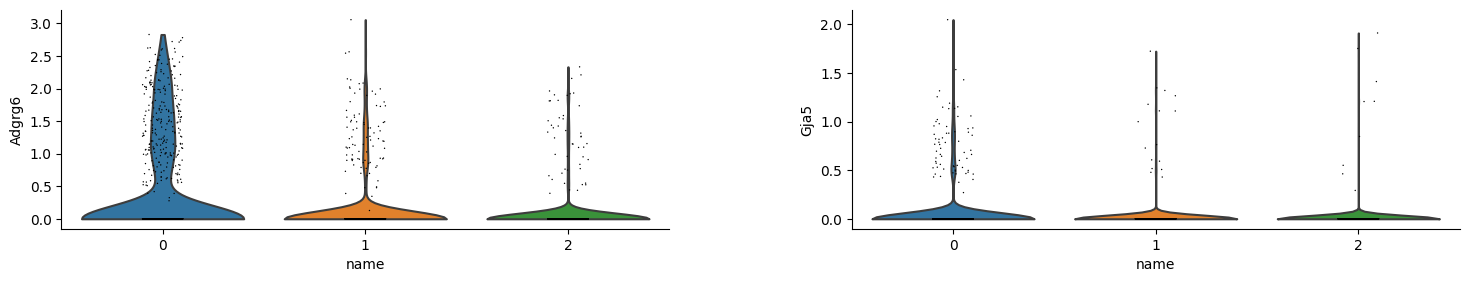

In [16]:
sc.pl.violin(hepadata,['Adgrg6','Gja5'], groupby='name')

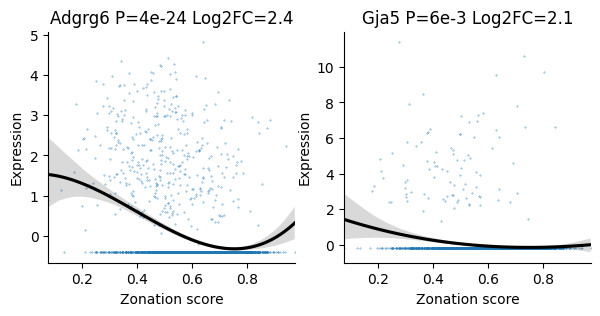

In [18]:
import seaborn as sns
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
figsize(7,3)
f, ax = plt.subplots(1,2)
df = sc.get.rank_genes_groups_df(hepadata, group="0",log2fc_min=0)
genelist=['Adgrg6','Gja5']
genedf =pd.DataFrame(hepadata[:,genelist].X.toarray(),index = hepadata.obs_names,columns=genelist)
genedf['pseudospace']=hepadata.obs.merged_pseudospace
for i in range(2):
    gn = genelist[i]
    sns.regplot(data=genedf,x='pseudospace',y=gn,order=3,scatter_kws=dict(s=0.1),line_kws=dict(color='black'),label=gn,ax=ax[i])
    if gn=='Adgrg6':
        ax[i].title.set_text(f'{gn} P=4e-24 Log2FC=2.4')
    else:
        ax[i].title.set_text(f'{gn} P=6e-3 Log2FC=2.1')
    # ax[i].set_ylim(0,3)
    ax[i].set_ylabel('Expression')
    ax[i].set_xlabel('Zonation score')
plt.savefig('../../result_liver/endotri2gene.pdf',bbox_inches='tight')

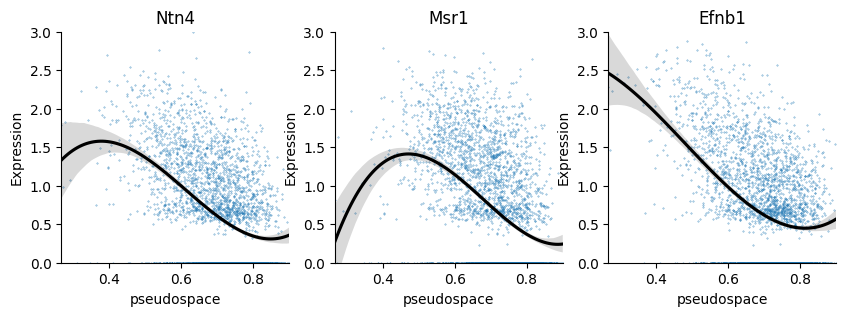

In [829]:
figsize(10,3)
f, ax = plt.subplots(1,3)
df = sc.get.rank_genes_groups_df(hepadata, group="0",log2fc_min=0,pval_cutoff=0.05)
genelist=df.names[:3].tolist()
genedf =pd.DataFrame(hepadata.raw[:,genelist].X.toarray(),index = hepadata.obs_names,columns=genelist)
genedf['pseudospace']=hepadata.obs.merged_pseudospace
for i in range(3):
    gn = genelist[i]
    sns.regplot(data=genedf,x='pseudospace',y=gn,order=3,scatter_kws=dict(s=0.1),line_kws=dict(color='black'),label=gn,ax=ax[i])
    ax[i].title.set_text(gn)
    ax[i].set_ylim(0,3)
    ax[i].set_ylabel('Expression')
plt.savefig('../../result_liver/endotri0.pdf',bbox_inches='tight')

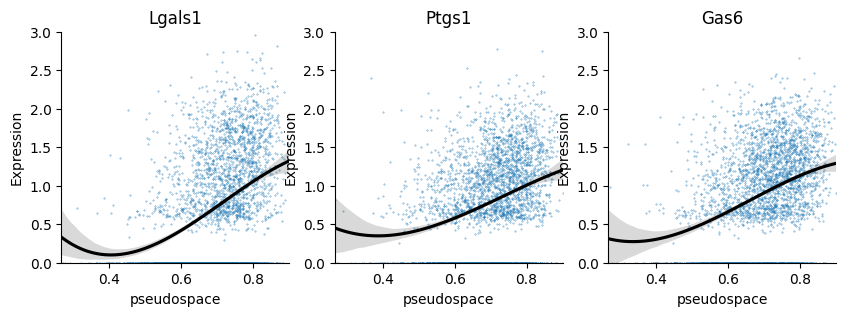

In [831]:
figsize(10,3)
f, ax = plt.subplots(1,3)
df = sc.get.rank_genes_groups_df(hepadata, group="2",log2fc_min=0.5,pval_cutoff=0.05)
genelist=df.names[3:6].tolist()
genedf =pd.DataFrame(hepadata.raw[:,genelist].X.toarray(),index = hepadata.obs_names,columns=genelist)
genedf['pseudospace']=hepadata.obs.merged_pseudospace
for i in range(3):
    gn = genelist[i]
    sns.regplot(data=genedf,x='pseudospace',y=gn,order=3,scatter_kws=dict(s=0.1),line_kws=dict(color='black'),label=gn,ax=ax[i])
    ax[i].title.set_text(gn)
    ax[i].set_ylim(0,3)
    ax[i].set_ylabel('Expression')
plt.savefig('../../result_liver/endotri2.pdf',bbox_inches='tight')

In [569]:
hepadata = nucadata[nucadata.obs.annot=='B cells'].copy()
hepadata = hepadata[:,stadata.var_names].copy()
sc.pp.normalize_total(hepadata)
sc.pp.log1p(hepadata)

def getpesudospace(stadata,stdata,scadata,scdata,testmodel):
    stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
    scembedding = testmodel.netE(torch.tensor(scdata,dtype=torch.float32).cuda())
    netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
    netsc2st = pd.DataFrame(netsc2st,index=scadata.obs_names.tolist(),columns=stdata.index)
    assert netsc2st.index.tolist() == scadata.obs_names.tolist()
    return netsc2st.values @ stadata.obs['zonation'].values

hepadata.obs['pseudospace'] = getpesudospace(stadata,stdata,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace2'] = getpesudospace(stadata2,stdata2,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace3'] = getpesudospace(stadata3,stdata3,hepadata,hepadata.X.todense(),testmodel)
hepadata.obs['pseudospace4'] = getpesudospace(stadata4,stdata4,hepadata,hepadata.X.todense(),testmodel)
merged_pseudospace = hepadata.obs[['pseudospace','pseudospace2','pseudospace3','pseudospace4']].mean(1)

In [570]:
cahepadata = nucadata[nucadata.obs.annot=='B cells'].copy()
sc.pp.normalize_total(cahepadata)
sc.pp.log1p(cahepadata)
sc.pp.highly_variable_genes(cahepadata)
sc.pp.scale(cahepadata)
sc.pp.pca(cahepadata)
sc.pp.neighbors(cahepadata)
sc.tl.umap(cahepadata)
cahepadata.obs['merged_pseudospace'] = merged_pseudospace

In [571]:
cahepadata

AnnData object with n_obs × n_vars = 1484 × 31053
    obs: 'UMAP_1', 'UMAP_2', 'cluster', 'annot', 'sample', 'digest', 'typeSample', 'n_genes_by_counts', 'total_counts', 'pseudospace', 'pseudospace2', 'pseudospace3', 'pseudospace4', 'leiden', 'merged_pseudospace'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'Umap_raw', 'spatialDA', 'spatialDAall', 'spatialDA2', 'spatialDAall2', 'spatialDA3', 'spatialDAall3', 'spatialDA4', 'spatialDAall4', 'X_pca', 'X_umap', 'X_oldumap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

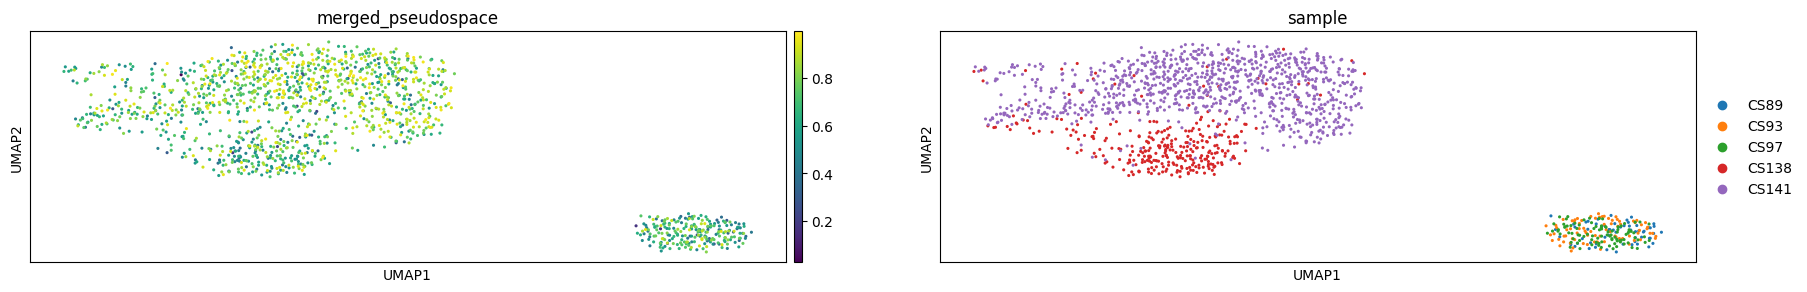

In [572]:
sc.pl.umap(cahepadata,color=['merged_pseudospace','sample'],s=20)

In [573]:
tmpnucadata = nucadata.copy()
sc.pp.normalize_total(tmpnucadata)
sc.pp.log1p(tmpnucadata)
cahepadata = tmpnucadata[tmpnucadata.obs.annot=='B cells'].copy()
cahepadata = cahepadata[:,stadata.var_names].copy()


testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(cahepadata.X.todense(),dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = pd.DataFrame(netsc2st,index=cahepadata.obs_names,columns=stdata.index)
spcoor1 = k_coord(netsc2st,spcoor,5)

### saliency map

In [474]:
from tqdm import tqdm
capt = Captummodel(testmodel.netE,stembedding.detach())
capt.eval()


allsali = []
allbestidx = []
alldelta = []
allscemb = []
for i in tqdm(range(cahepadata.shape[0])):
    inputdata = torch.tensor(cahepadata.X.toarray()[i]).cuda().unsqueeze(0)
    scembedding = testmodel.netE(inputdata)
    allscemb.append(scembedding.detach().cpu().numpy())
    spinal2st = scembedding.mm(stembedding.detach().t())
    idx = spinal2st.argmax()
    ig = IntegratedGradients(capt)
    # nt = NoiseTunnel(ig)    
    attributions,delta = ig.attribute(inputdata,target=idx,return_convergence_delta=True)
    # attributions, delta = nt.attribute(inputdata,baselines= torch.rand_like(inputdata)*0.01,nt_type='smoothgrad', stdevs=0.02, nt_samples=5, target=idx, return_convergence_delta=True)
    allsali.append(attributions.detach().cpu().numpy()[0])
    alldelta.append(delta.mean().item())

allsali = np.array(allsali)

100%|██████████| 1484/1484 [00:15<00:00, 96.30it/s]


In [479]:
saliadata = sc.AnnData(pd.DataFrame(allsali,columns=scdata.columns,index = cahepadata.obs_names),obs = cahepadata.obs)
saliadata.obsm['spatialDA'] = spcoor1
saliadata.obs['merged_pseudospace'] = merged_pseudospace

In [480]:
sc.pp.highly_variable_genes(saliadata)
saliadata.raw = saliadata
sc.pp.scale(saliadata)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [481]:
saliadata.obs['name']='0'
# Qtlist = np.arange(20,100,20).tolist()
Qtlist = [1/3*100,2/3*100]

inter = Qtlist[1] - Qtlist[0]
for i in range(len(Qtlist)):
    Qt = Qtlist[i]
    Q1 = np.percentile(saliadata.obs['merged_pseudospace'],Qt)
    Q2 = np.percentile(saliadata.obs['merged_pseudospace'],Qt+inter)
    saliadata.obs.loc[(saliadata.obs['merged_pseudospace']>=Q1)&(saliadata.obs['merged_pseudospace']<Q2),'name']=str(int(i+1))
saliadata.obs['name'] = saliadata.obs['name'].astype('category')

In [482]:
sc.tl.rank_genes_groups(saliadata,groupby='name',method='wilcoxon',pts=True)

/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/hms/anaconda3/envs/scpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [483]:
dedf = sc.get.rank_genes_groups_df(saliadata, group="0",pval_cutoff=0.05)
dedf.query('(scores>0)&(pvals_adj<0.05)')

names    scores  logfoldchanges         pvals     pvals_adj  \
0           Cd79b  8.740284       -1.250155  2.325248e-18  5.657327e-15   
1           Iglc2  8.385993       -1.249498  5.029913e-17  6.118889e-14   
2            Jund  7.870801       -1.572412  3.523761e-15  3.429325e-12   
3   4930523C07Rik  7.692051             NaN  1.447948e-14  1.174286e-11   
4             Fus  7.564730             NaN  3.886716e-14  2.701823e-11   
..            ...       ...             ...           ...           ...   
68          Rsrp1  3.280817       -0.541876  1.035069e-03  4.008271e-02   
69           Lgmn  3.280046             NaN  1.037900e-03  4.008271e-02   
70        Ppp4r3b  3.262261       -2.701327  1.105272e-03  4.183274e-02   
71          Sdcbp  3.259308        1.389888  1.116844e-03  4.183274e-02   
72         Tomm34  3.259115             NaN  1.117603e-03  4.183274e-02   

    pct_nz_group  pct_nz_reference  
0       0.983871          0.993927  
1       0.943548          0.942308  
2       0.907258          0.902834  
3       0.689516          0.716599  
4       0.663306          0.660931  
..           ...               ...  
68      0.612903          0.636640  
69      0.330645          0.310729  
70      0.304435          0.349190  
71      0.316532          0.347166  
72      0.185484          0.219636  

[73 rows x 7 columns]

In [484]:
dedf = sc.get.rank_genes_groups_df(saliadata, group="1",pval_cutoff=0.05)
dedf.query('(scores>0)&(pvals_adj<0.05)')

Empty DataFrame
Columns: [scores, logfoldchanges, pvals, pvals_adj, pct_nz_group, names, pct_nz_reference]
Index: []

In [485]:
dedf = sc.get.rank_genes_groups_df(saliadata, group="2",pval_cutoff=0.05)
dedf.query('(scores>0)&(pvals_adj<0.05)')

names    scores  logfoldchanges         pvals     pvals_adj  \
0      Celf2  8.067834             NaN  7.155641e-16  1.160645e-12   
1      Blvrb  7.454687        4.296026  9.008172e-14  8.766753e-11   
2     H2-Eb1  6.907610             NaN  4.928860e-12  2.795864e-09   
3      H2-Aa  6.860050        4.433625  6.883667e-12  3.349592e-09   
4      Sgms1  6.756830        2.407202  1.410435e-11  5.279367e-09   
..       ...       ...             ...           ...           ...   
72    Man2b1  3.236440        7.164660  1.210307e-03  4.061623e-02   
73     Tcea1  3.221015        0.740055  1.277375e-03  4.199803e-02   
74    Mapre1  3.209317        1.902265  1.330505e-03  4.316157e-02   
75  BC031181  3.206104        1.309387  1.345454e-03  4.335747e-02   
76    Nap1l1  3.166256        1.795172  1.544149e-03  4.911000e-02   

    pct_nz_group  pct_nz_reference  
0       0.680162          0.589899  
1       0.479757          0.416162  
2       0.991903          0.971717  
3       0.987854          0.985859  
4       0.461538          0.347475  
..           ...               ...  
72      0.408907          0.406061  
73      0.348178          0.288889  
74      0.317814          0.276768  
75      0.295547          0.268687  
76      0.736842          0.659596  

[77 rows x 7 columns]

Trying to set attribute `.uns` of view, copying.


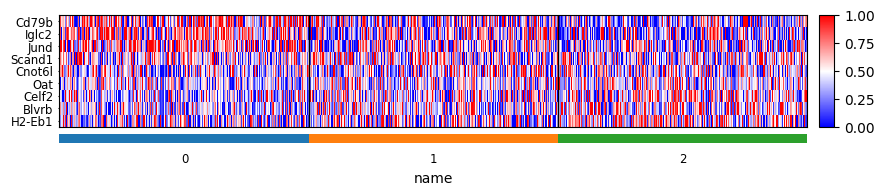

In [486]:
rkgene = pd.DataFrame(saliadata.uns['rank_genes_groups']['names'])
N=3
topgenelist = []
reclusterindex = np.arange(3)
for i in reclusterindex:
    topgenelist += rkgene.iloc[:N,i].tolist()

spa_plotgenelist=[]
for x in topgenelist:
    if x not in spa_plotgenelist:
        spa_plotgenelist.append(x)

cellrank = saliadata.obs['merged_pseudospace'].sort_values().index
sc.pl.heatmap(saliadata[cellrank,:],var_names=spa_plotgenelist,groupby='name',cmap='bwr',standard_scale ='obs',swap_axes=True,use_raw=False)

In [487]:
sc.pp.pca(saliadata)
sc.pp.neighbors(saliadata)
sc.tl.umap(saliadata)

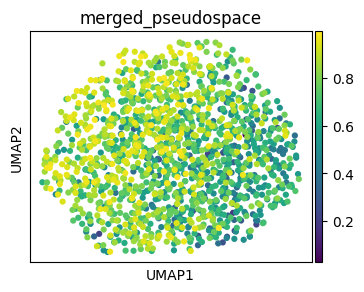

In [488]:
sc.pl.umap(saliadata,color='merged_pseudospace')

### DE

In [578]:
hepadata = nucadata[nucadata.obs.annot=='B cells'].copy()
# hepadata = hepadata[hepadata.obs['sample'].isin(['ABU11','ABU12','ABU13']),:].copy()
hepadata.obs['merged_pseudospace'] = merged_pseudospace
hepadata.obsm['spatialDA'] = spcoor1

In [579]:
sc.pp.filter_genes(hepadata,min_cells=10)
sc.pp.normalize_total(hepadata)
sc.pp.log1p(hepadata)
sc.pp.highly_variable_genes(hepadata)
hepadata.raw = hepadata
sc.pp.scale(hepadata)
# sc.pp.pca(hepadata)
# sc.pp.neighbors(hepadata)
# sc.tl.umap(hepadata)

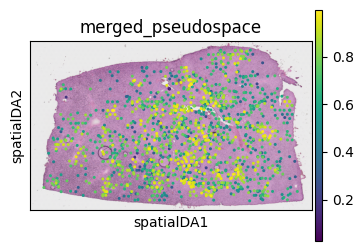

In [580]:
hepadata.uns['spatial'] = stadata.uns['spatial']

figsize(4,3)
sc.pl.spatial(hepadata,spot_size=20,basis='spatialDA',color=['merged_pseudospace'])

In [581]:
newobsm = np.concatenate([hepadata.obs.merged_pseudospace.values.reshape(-1,1),np.ones([hepadata.shape[0],1])],axis=1)
hepadata.obsm['space']=newobsm
sc.pp.neighbors(hepadata,use_rep='space')

In [582]:
hepadata.obs['name']='0'
# Qtlist = np.arange(20,100,20).tolist()
Qtlist = [1/3*100,2/3*100]

inter = Qtlist[1] - Qtlist[0]
for i in range(len(Qtlist)):
    Qt = Qtlist[i]
    Q1 = np.percentile(hepadata.obs['merged_pseudospace'],Qt)
    Q2 = np.percentile(hepadata.obs['merged_pseudospace'],Qt+inter)
    hepadata.obs.loc[(hepadata.obs['merged_pseudospace']>=Q1)&(hepadata.obs['merged_pseudospace']<Q2),'name']=str(int(i+1))
hepadata.obs['name'] = hepadata.obs['name'].astype('category')

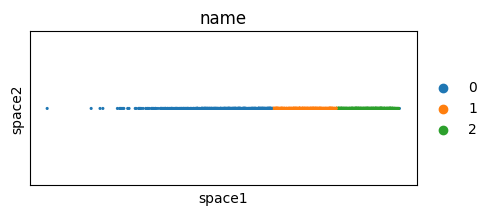

In [583]:
figsize(5,2)
sc.pl.embedding(hepadata,color=['name'],basis='space',s=20)

In [591]:
hepadata = hepadata[hepadata.obs.name.isin(['0','2'])]

In [592]:
sc.tl.rank_genes_groups(hepadata,groupby='name',method='wilcoxon',pts=True)

Trying to set attribute `.uns` of view, copying.


In [496]:
# hepadata.write('Liver_mouse_sample1_B_all.h5ad')

# hepadata = sc.read_h5ad('Liver_mouse_sample1_B_all.h5ad')

In [594]:
dedf = sc.get.rank_genes_groups_df(hepadata, group="0",log2fc_min=0,pval_cutoff=0.05)
dedf

names    scores  logfoldchanges         pvals     pvals_adj  \
0         Alb  8.363341        2.146386  6.096654e-17  6.590483e-13   
1       Apoa2  7.653410        2.069758  1.957189e-14  1.057861e-10   
2        Apoe  7.327510        0.954397  2.344673e-13  6.336478e-10   
3       Apoa1  6.964375        2.004353  3.298647e-12  5.943062e-09   
4   Serpina3k  6.885679        2.046031  5.751252e-12  8.881576e-09   
..        ...       ...             ...           ...           ...   
57       Ass1  3.673148        1.441777  2.395810e-04  2.466543e-02   
58    Selenop  3.559550        0.595937  3.714912e-04  3.617856e-02   
59       Scp2  3.520646        0.768557  4.304964e-04  4.083874e-02   
60      Aldob  3.495526        1.890851  4.731286e-04  4.371385e-02   
61      Gsta3  3.470628        1.890725  5.192434e-04  4.600837e-02   

    pct_nz_group  pct_nz_reference  
0       0.510081          0.236842  
1       0.441532          0.182186  
2       0.883065          0.838057  
3       0.391129          0.145749  
4       0.387097          0.147773  
..           ...               ...  
57      0.241935          0.115385  
58      0.516129          0.465587  
59      0.516129          0.475709  
60      0.191532          0.066802  
61      0.189516          0.064777  

[62 rows x 7 columns]

In [595]:
dedf = sc.get.rank_genes_groups_df(hepadata, group="2",log2fc_min=0,pval_cutoff=0.05)
dedf

names    scores  logfoldchanges         pvals     pvals_adj  \
0     Cd74  7.495129        0.364149  6.623340e-14  2.386610e-10   
1    H2-Aa  7.192460        0.457152  6.363414e-13  1.375770e-09   
2    Cd79a  6.323803        0.337622  2.552033e-10  3.448434e-07   
3    Rpl34  6.096385        0.266085  1.084941e-09  9.773513e-07   
4   H2-Eb1  6.046700        0.378815  1.478431e-09  1.141560e-06   
..     ...       ...             ...           ...           ...   
56   Rpl35  3.491080        0.233307  4.810726e-04  4.407115e-02   
57    Gmfg  3.488190        0.380667  4.863028e-04  4.417591e-02   
58    Rhoh  3.483299        0.408291  4.952747e-04  4.461600e-02   
59   Rps27  3.475074        0.181918  5.107129e-04  4.562650e-02   
60   Actr3  3.462513        0.305412  5.351550e-04  4.703273e-02   

    pct_nz_group  pct_nz_reference  
0       1.000000          0.997984  
1       0.987854          0.981855  
2       0.997976          0.989919  
3       1.000000          0.997984  
4       0.991903          0.961694  
..           ...               ...  
56      0.981781          0.955645  
57      0.777328          0.641129  
58      0.690283          0.556452  
59      1.000000          0.995968  
60      0.829960          0.756048  

[61 rows x 7 columns]

In [597]:
rkgene = pd.DataFrame(hepadata.uns['rank_genes_groups']['names'])
N=2
topgenelist = []
reclusterindex = np.arange(2)
for i in reclusterindex:
    topgenelist += rkgene.iloc[:N,i].tolist()

spa_plotgenelist=[]
for x in topgenelist:
    if x not in spa_plotgenelist:
        spa_plotgenelist.append(x)

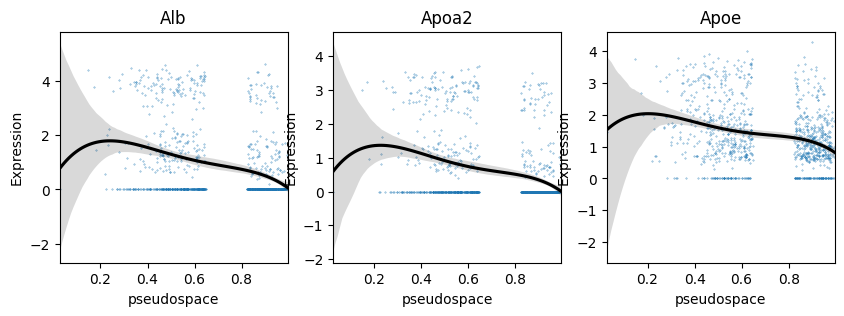

In [598]:
figsize(10,3)
f, ax = plt.subplots(1,3)
df = sc.get.rank_genes_groups_df(hepadata, group="0",log2fc_min=0)
genelist=df.names[:3].tolist()
genedf =pd.DataFrame(hepadata.raw[:,genelist].X.toarray(),index = hepadata.obs_names,columns=genelist)
genedf['pseudospace']=hepadata.obs.merged_pseudospace
for i in range(3):
    gn = genelist[i]
    sns.regplot(data=genedf,x='pseudospace',y=gn,order=4,scatter_kws=dict(s=0.1),line_kws=dict(color='black'),label=gn,ax=ax[i])
    ax[i].title.set_text(gn)
    ax[i].set_ylabel('Expression')

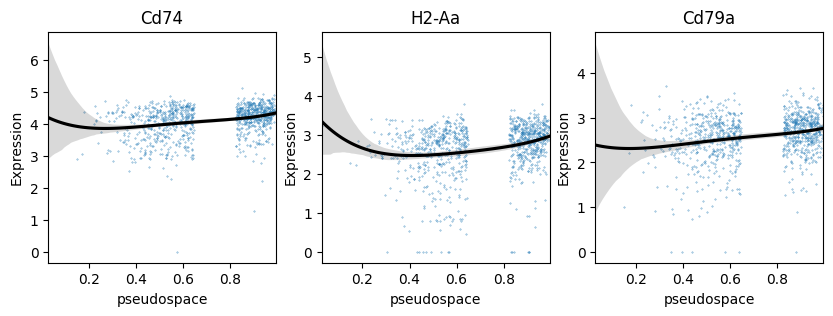

In [599]:
figsize(10,3)
f, ax = plt.subplots(1,3)
df = sc.get.rank_genes_groups_df(hepadata, group="2",log2fc_min=0)
genelist=df.names[:3].tolist()
genedf =pd.DataFrame(hepadata.raw[:,genelist].X.toarray(),index = hepadata.obs_names,columns=genelist)
genedf['pseudospace']=hepadata.obs.merged_pseudospace
for i in range(3):
    gn = genelist[i]
    sns.regplot(data=genedf,x='pseudospace',y=gn,order=4,scatter_kws=dict(s=0.1),line_kws=dict(color='black'),label=gn,ax=ax[i])
    ax[i].title.set_text(gn)
    ax[i].set_ylabel('Expression')

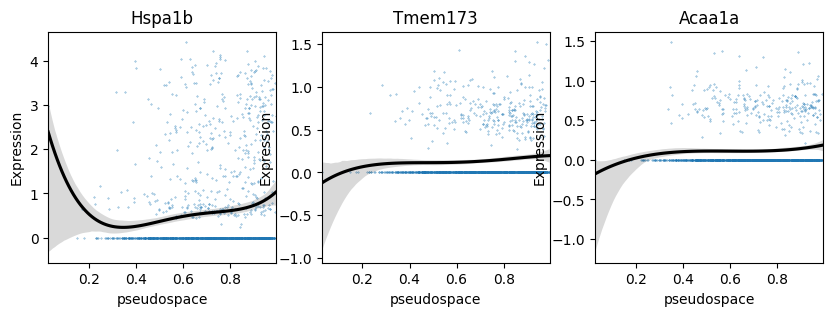

In [503]:
figsize(10,3)
f, ax = plt.subplots(1,3)
df = sc.get.rank_genes_groups_df(hepadata, group="2",log2fc_min=0.5)
genelist=df.names[3:6].tolist()
genedf =pd.DataFrame(hepadata.raw[:,genelist].X.toarray(),index = hepadata.obs_names,columns=genelist)
genedf['pseudospace']=hepadata.obs.merged_pseudospace
for i in range(3):
    gn = genelist[i]
    sns.regplot(data=genedf,x='pseudospace',y=gn,order=4,scatter_kws=dict(s=0.1),line_kws=dict(color='black'),label=gn,ax=ax[i])
    ax[i].title.set_text(gn)
    ax[i].set_ylabel('Expression')